In [7]:
# Cell 1: Load and prepare data

import pandas as pd
import numpy as np

# Load dataset and parse datetime
df = pd.read_csv("SeoulBikeDataClean.csv", parse_dates=["datetime"])

# Filter only functioning days
df = df[df['functioning_day'] == 'Yes'].copy()

# Add original target and log-transformed target
df['target'] = df['rented_bike_count']
df['target_log'] = np.log1p(df['target'])

# Time-based split
train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("✅ Data loaded and split:")
print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)


✅ Data loaded and split:
Train: (7152, 38)
Val:   (665, 38)
Test:  (648, 38)


In [8]:
# Cell 2: Define features and preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Features to use (includes 3 new interaction terms)
all_features = [
    'hour', 'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2', 'rainfallmm', 'snowfall_cm',
    'seasons', 'holiday', 'weekday', 'month', 'time_bin',
    'is_raining', 'is_snowing', 'temperaturec_squared',
    'is_weekend', 'is_holiday', 'is_working_day',
    'temp_rain', 'temp_snow', 'humid_rain'
]

# Separate numeric and categorical columns
numeric_features = [
    'temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m',
    'dew_point_temperaturec', 'solar_radiation_mj_m2',
    'rainfallmm', 'snowfall_cm', 'temperaturec_squared',
    'temp_rain', 'temp_snow', 'humid_rain'
]
categorical_features = list(set(all_features) - set(numeric_features))

# ColumnTransformer to preprocess features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Apply to train/val/test
X_train = train_df[all_features]
y_train = train_df['target_log']
X_val   = val_df[all_features]
y_val   = val_df['target_log']
X_test  = test_df[all_features]
y_test  = test_df['target']  # Keep original scale for final inverse transform

# Fit-transform
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

print("✅ Feature processing complete. Transformed shape:")
print("Train:", X_train_proc.shape)
print("Val:  ", X_val_proc.shape)
print("Test: ", X_test_proc.shape)


✅ Feature processing complete. Transformed shape:
Train: (7152, 74)
Val:   (665, 74)
Test:  (648, 74)


In [9]:
# Cell 3: Train XGBoost with log-transformed target

import xgboost as xgb

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train_proc, label=y_train)
dval   = xgb.DMatrix(X_val_proc, label=y_val)

params = {
    'objective': 'reg:squarederror',
    'eta': 0.05,
    'max_depth': 6,
    'eval_metric': 'rmse',
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=20
)

print("✅ Model training complete.")


[0]	train-rmse:1.12404	eval-rmse:1.12396


[20]	train-rmse:0.58392	eval-rmse:0.76074
[40]	train-rmse:0.40824	eval-rmse:0.68036
[60]	train-rmse:0.33929	eval-rmse:0.64700
[80]	train-rmse:0.30772	eval-rmse:0.63358
[100]	train-rmse:0.28728	eval-rmse:0.62726
[120]	train-rmse:0.27133	eval-rmse:0.62085
[140]	train-rmse:0.25856	eval-rmse:0.61480
[160]	train-rmse:0.24807	eval-rmse:0.61032
[180]	train-rmse:0.23756	eval-rmse:0.60581
[200]	train-rmse:0.22944	eval-rmse:0.60323
[213]	train-rmse:0.22248	eval-rmse:0.60477
✅ Model training complete.


📊 Test RMSE: 396.63
📊 Test R²:   0.2417


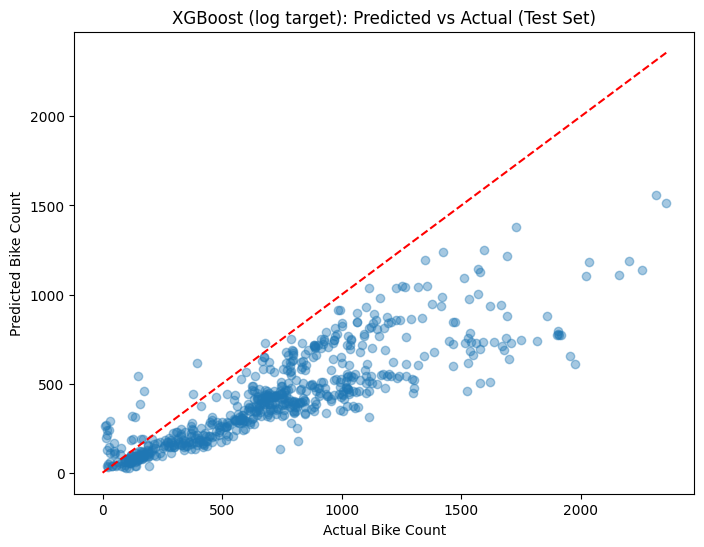

In [10]:
# Cell 4: Predict on test set and evaluate in original scale

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict log-transformed
dtest = xgb.DMatrix(X_test_proc)
y_test_log_pred = xgb_model.predict(dtest)

# Inverse transform to original scale
y_test_pred = np.expm1(y_test_log_pred)  # inverse of log1p

# Compute evaluation metrics
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)

print(f"📊 Test RMSE: {rmse:.2f}")
print(f"📊 Test R²:   {r2:.4f}")

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.title("XGBoost (log target): Predicted vs Actual (Test Set)")
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.show()
